In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

In [2]:
columns = ['alpha1', 'alpha9', 'alpha21', 'alpha26', 'alpha48', 'alpha49', 'target']

In [3]:
Final_df = pd.read_excel("F:\Alabama_Internship\EEG\Deepesh Code\Datasets\Dataset_alpha_peak.xlsx")
df = Final_df[columns]

X = df.iloc[:, : -1].values
y = df.iloc[:, -1].values

X = pd.DataFrame(X)
y = pd.DataFrame(y)

Participants_count = len(Final_df.index)//2

LR_scores = []
XGB_scores = []
KNN_scores = []
SVM_scores = []
KSVM_scores = []
NB_scores = []
DTC_scores = []
RFC_scores = []
Model_scores_list = []

In [4]:
X.head()

,0,1,2,3,4,5
0,9.072383,11.720649,9.079279,9.082727,9.075831,9.075831
1,9.455140,10.920652,11.727546,9.617208,10.134448,10.127551
2,8.003421,10.668929,8.893073,10.717204,9.975828,9.979276
3,10.079276,10.489619,9.741346,10.534446,10.724101,10.458585
4,9.279278,9.620656,9.610312,9.244796,8.693073,9.337899


For Leave one out cross validation (LOOCV method), drop out the pre and post info related to one participant, train the model using the remaining data. Test the model using the info which was dropped during the training stage.

In [5]:
print(Participants_count)

20


In [6]:
import shap

aggregated_shap_values = np.zeros((2, 6), dtype='float32')

for i in range(Participants_count):

    X_train = X.drop(labels = [i, i + Participants_count], axis=0)
    y_train = y.drop(labels = [i, i + Participants_count], axis=0)
    X_test = X.iloc[[i, i + Participants_count],:] 
    y_test = y.iloc[[i, i + Participants_count],:] 

    if(i==0):
        X_train.to_excel("X_dataframe.xlsx")
        y_train.to_excel("y_dataframe.xlsx")

    # Feature Scaling

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Dimensionality Reduction

    # PCA - Principle Component Analysis

    #pca = PCA(n_components = 0.95)
    #X_train = pca.fit_transform(X_train)
    #X_test = pca.transform(X_test)
    #explained_variance = pca.explained_variance_ratio_
    #print(explained_variance)

    # LDA - Linear Discriminant Analysis

    #lda = LDA(n_components = 1)
    #X_train = lda.fit_transform(X_train,y_train)
    #X_test = lda.transform(X_test)

    # ML Models Accuracy Computation

    LR_classifier = LogisticRegression(random_state = 0)
    LR_classifier.fit(X_train, y_train)
    LR_scores.append(LR_classifier.score(X_test,y_test))

    XGB_classifier = XGBClassifier()
    XGB_classifier.fit(X_train, y_train)
    XGB_scores.append(XGB_classifier.score(X_test,y_test))
    #plt.bar(range(len(XGB_classifier.feature_importances_)), XGB_classifier.feature_importances_)
    #plt.show()
    # Getting SHAP values

    explainer = shap.Explainer(XGB_classifier)
    shap_values = explainer.shap_values(X_test)
    aggregated_shap_values += shap_values


    KNN_classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
    KNN_classifier.fit(X_train, y_train)
    KNN_scores.append(KNN_classifier.score(X_test,y_test))

    SVM_classifier = SVC(kernel = 'linear', random_state = 0)
    SVM_classifier.fit(X_train, y_train)
    SVM_scores.append(SVM_classifier.score(X_test,y_test))

    KSVM_classifier = SVC(kernel = 'rbf', random_state = 0)
    KSVM_classifier.fit(X_train, y_train)
    KSVM_scores.append(KSVM_classifier.score(X_test,y_test))

    NB_classifier = GaussianNB()
    NB_classifier.fit(X_train, y_train)
    NB_scores.append(NB_classifier.score(X_test,y_test))

    DTC_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    DTC_classifier.fit(X_train, y_train)
    DTC_scores.append(DTC_classifier.score(X_test,y_test))

    RFC_classifier = RandomForestClassifier(random_state=0)
    RFC_classifier.fit(X_train, y_train)
    RFC_scores.append(RFC_classifier.score(X_test,y_test))

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


[0.61454654 0.33119503 0.5243268  0.09607208 0.06991501 0.15230018]
[0 2 1 5 3 4]


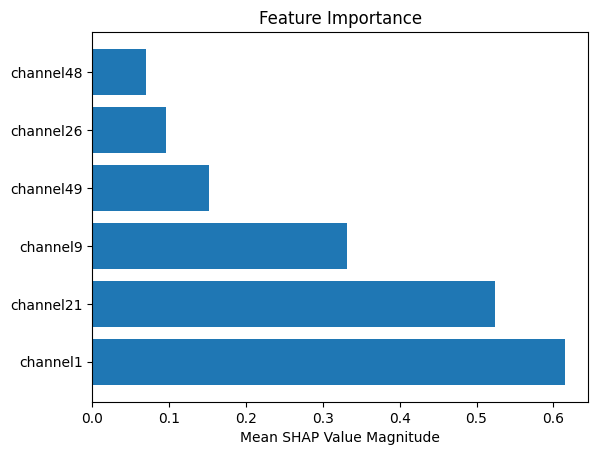

In [7]:
mean_shap_values = aggregated_shap_values / 20
feature_importance = np.mean(np.abs(mean_shap_values), axis=0)

sorted_indices = np.argsort(feature_importance)[::-1]
print(feature_importance)
print(sorted_indices)
sorted_feature_importance = feature_importance[sorted_indices]
ynames = ['channel1', 'channel9', 'channel21', 'channel26', 'channel48', 'channel49', 'target']
feature_names = np.array(ynames[:-1])
sorted_feature_names = feature_names[sorted_indices]  # Replace with your feature names

# Visualize feature importance
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Mean SHAP Value Magnitude')
plt.title('Feature Importance')
plt.show()

We print out the mean of the accuracies obtained through each of the ML models

In [8]:
model_str = ["Logistic Regression","XG Boost", "KNN", "SVM", "Kernel SVM", "Naive Bayes", "Decision Trees Classifier", "Random Forest Classifier"]

Model_scores_list.append(LR_scores)
Model_scores_list.append(XGB_scores)
Model_scores_list.append(KNN_scores)
Model_scores_list.append(SVM_scores)
Model_scores_list.append(KSVM_scores)
Model_scores_list.append(NB_scores)
Model_scores_list.append(DTC_scores)
Model_scores_list.append(RFC_scores)

for i in range(len(model_str)):

    print(model_str[i] + " Score : " + str(mean(Model_scores_list[i])))

Logistic Regression Score : 0.8
XG Boost Score : 0.85
KNN Score : 0.55
SVM Score : 0.825
Kernel SVM Score : 0.775
Naive Bayes Score : 0.65
Decision Trees Classifier Score : 0.775
Random Forest Classifier Score : 0.625


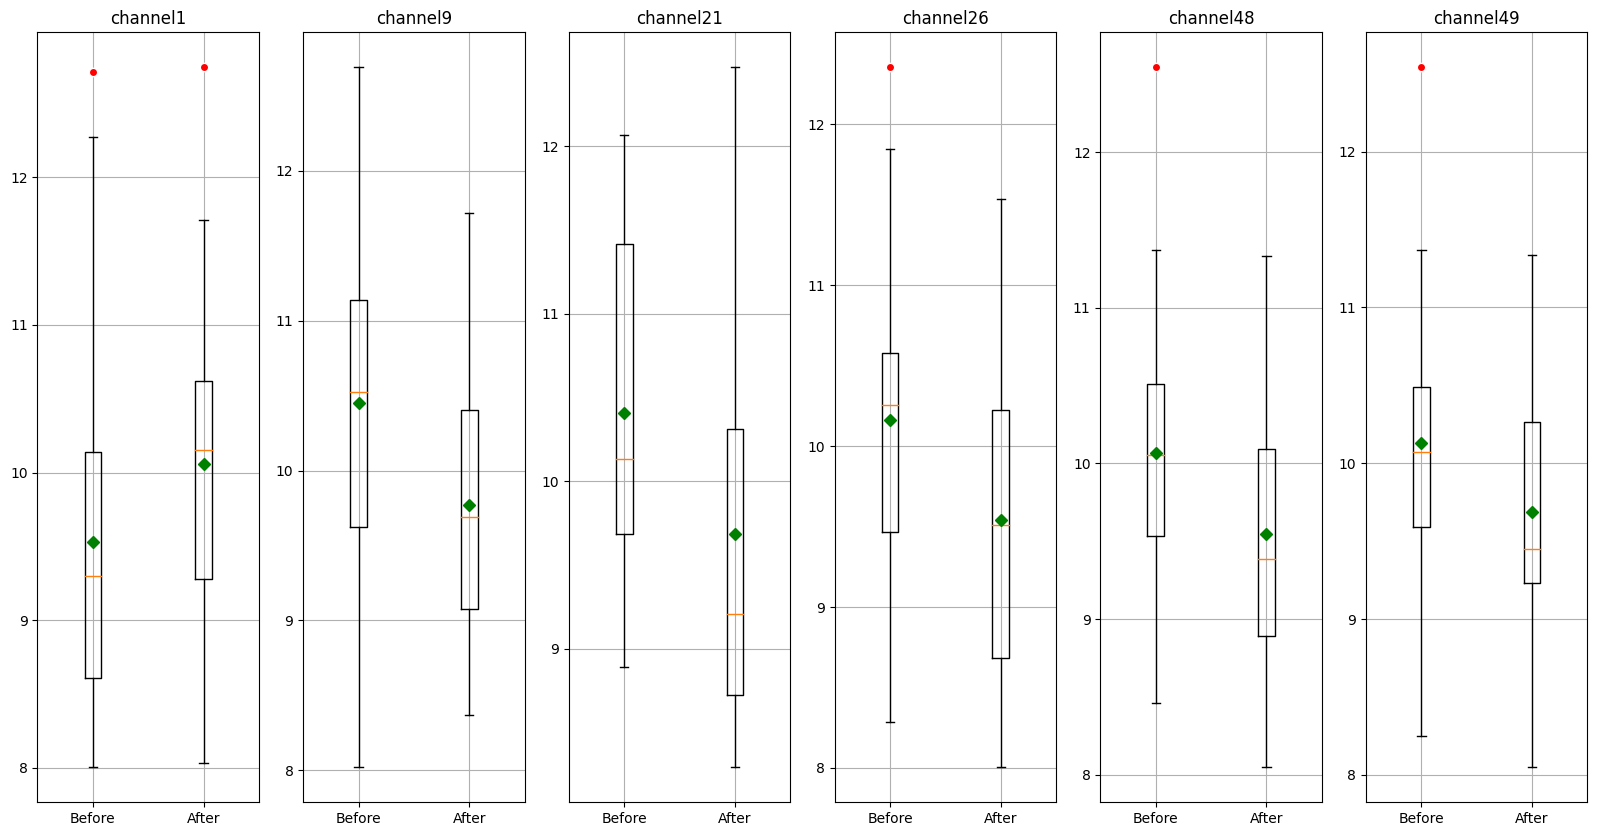

In [9]:
Final_df = pd.read_excel("F:\Alabama_Internship\EEG\Deepesh Code\Datasets\Dataset_alpha_peak.xlsx")
df = Final_df[columns]
names = ['channel1', 'channel9', 'channel21', 'channel26', 'channel48', 'channel49']

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

plt.figure(figsize=(20, 10))

X = df.iloc[:, : -1].values
l = X.T.tolist()
for i in range(len(columns) - 1):
    pre = l[i][0:20]
    post = l[i][20: 40]
    plt.subplot(1, 6, i + 1)
    plt.boxplot([pre, post], flierprops=red_circle, showmeans=True, meanprops=mean_shape, labels=['Before', 'After'])
    plt.title(names[i])
    plt.grid()

plt.show()
    

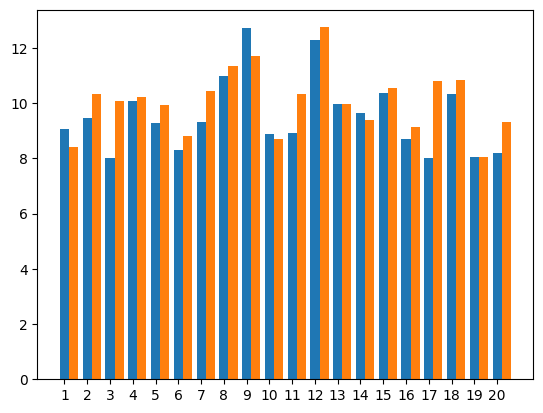

In [10]:
list = df['alpha1'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()

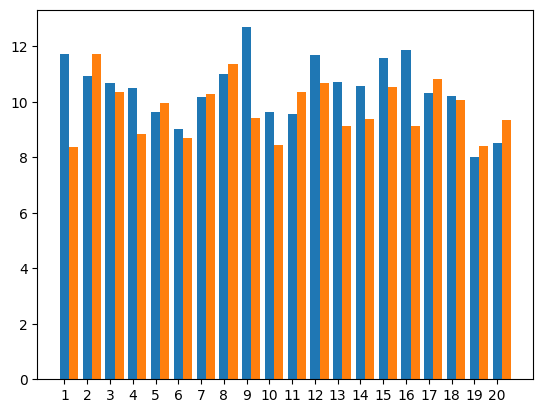

In [11]:
list = df['alpha9'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()

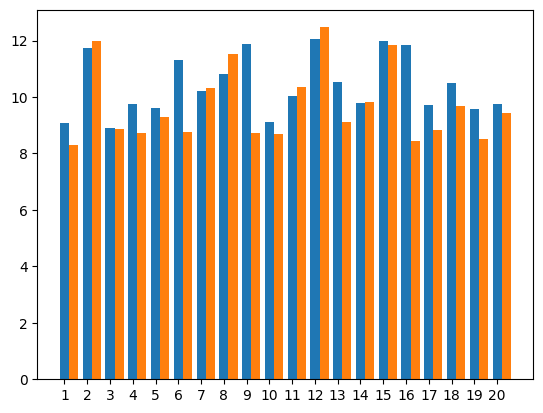

In [12]:
list = df['alpha21'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()

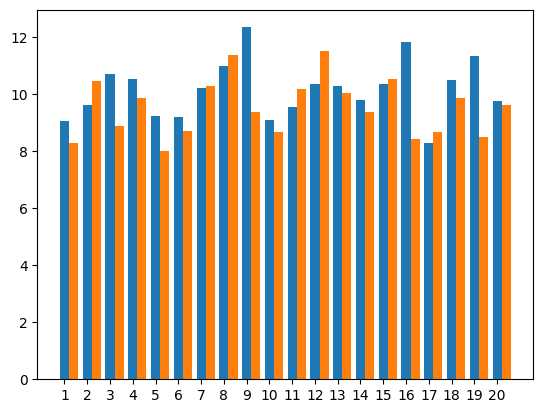

In [13]:
list = df['alpha26'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()

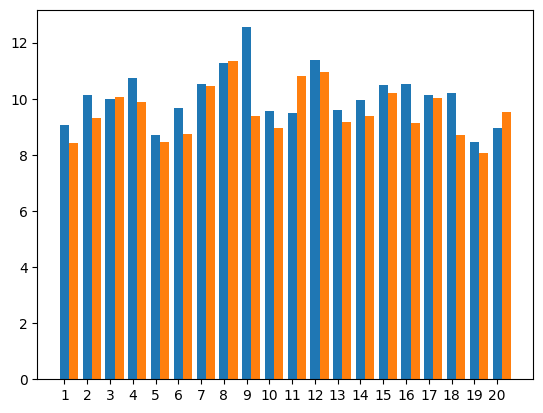

In [14]:
list = df['alpha48'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()

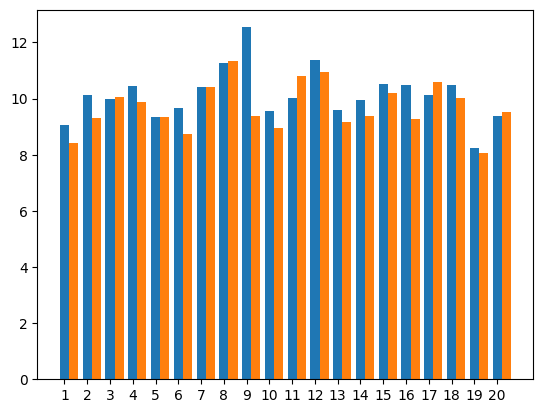

In [15]:
list = df['alpha49'].tolist()
before = list[:20]
after = list[20:]
patients = []

for i in range(20):
    patients.append(i + 1)

# plt.bar(patients, before, color ='maroon', width = 0.4)
# plt.bar(patients, after, color ='green', width = 0.4)
plt.bar(patients, before, width = 0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in patients], after, width = 0.4, label='After', align='center')

plt.xticks(patients)
plt.show()